In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
import math
import time
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from scipy.spatial import distance

In [63]:
def preprocess_features(x1, x2, reversed=False):
    x1_size, x2_size = len(x1), len(x2)
    features = np.array([np.concatenate((x2[j][:-1], x1[i][:-1])) if reversed else np.concatenate((x1[i][:-1], x2[j][:-1])) 
                         for i in range(x1_size) for j in range(x2_size)])   
    labels = np.array([(x2[j][-1] - x1[i][-1]) if reversed else (x1[i][-1] - x2[j][-1]) 
                       for i in range(x1_size) for j in range(x2_size)])
    return features, labels

In [64]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [65]:
def find_yn(z, y_sum, N):
    return np.array([(y_sum + sum(z[i: i + N])) / N for i in range(0, len(z), N)])

In [66]:
train_dataset_path = "./datasets/BodyFat_train.txt"
test_dataset_path = "./datasets/BodyFat_test.txt"

In [67]:
train_data = np.loadtxt(train_dataset_path,delimiter=',')
test_data = np.loadtxt(test_dataset_path,delimiter=',')

In [68]:
X_train, y_train = np.loadtxt(train_dataset_path,delimiter=',')[:,:-1], np.loadtxt(train_dataset_path,delimiter=',')[:,-1:]
X_test, y_test = np.loadtxt(test_dataset_path,delimiter=',')[:,:-1], np.loadtxt(test_dataset_path,delimiter=',')[:,-1:]

In [69]:
# train_data = pd.read_csv("./datasets/train_energy_eff_Y1.csv").drop(['Unnamed: 0'],axis=1).to_numpy()
# test_data = pd.read_csv("./datasets/test_energy_eff_Y1.csv").drop(['Unnamed: 0'],axis=1).to_numpy()

In [70]:
# X_train, y_train = train_data[:,:-1], train_data[:,-1:]
# X_test, y_test = test_data[:,:-1], test_data[:,-1:]

In [71]:
X = np.concatenate((train_data,test_data),axis=0)

In [72]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def sscore(k, X):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit_predict(X)
    return silhouette_score(X, km.labels_, metric='euclidean')
    
k_min,k_max = 1,12
ss = []
for k in range(k_min, k_max):
    if k > 1:
        ss.append(sscore(k, X))
    else: 
        ss.append(1)

# fig, ax = plt.subplots(figsize=(12, 4))  # Create a single plot

# kx = range(k_min, k_max)

# ax.set_ylim((0, 1.05))
# ax.set_xticks(kx)
# ax.axhline(y=0.8, color='r', linestyle='-')
# ax.plot(kx, ss, c='green')
# ax.scatter(kx, ss, c='green', marker='o')
# ax.set_xlabel('X Values')
# ax.set_ylabel('Y Values')
# ax.set_title('Combined Line and Scatter Plot')
# ax.legend()

# plt.show()

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
n_clusters = 4
# без виход
kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init="auto").fit(X_train)

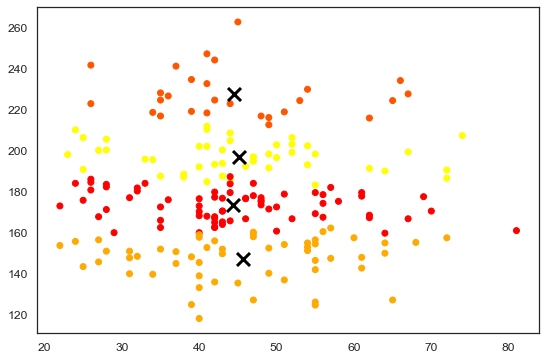

In [75]:
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)
plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c=kmeans.labels_, cmap='autumn')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.show()

In [76]:
def calculate_cluster_centers(k, data,best_labels):

    cluster, count = np.unique(best_labels,return_counts=True)
    clusters_y = {i:0 for i in range(k)}
    for index, cluster in enumerate(best_labels):
        clusters_y[cluster] += data[index]
    
    for k in clusters_y.keys():
        clusters_y[k] /= count[k] 
        
    
    return clusters_y

        
cluster_centers_y = calculate_cluster_centers(n_clusters, y_train.flatten(),kmeans.labels_)
# cluster_centers = np.hstack((kmeans_train.cluster_centers_,np.array(list(cluster_centers_y.values())).reshape(-1,1)))
new_y_train = [cluster_centers_y[label] for label in kmeans.labels_]

In [77]:
def euclidean_distance(vector1, vector2):
    return np.linalg.norm(vector1-vector2)

def find_closest_cluster(vector, cluster_centers):
    min_distance = float("inf")
    min_distance_index = float("inf")
    
    for index, cluster in enumerate(cluster_centers):
       distance = euclidean_distance(vector, cluster)

       if distance < min_distance:
           min_distance = distance
           min_distance_index = index
    
    return min_distance_index

test_labels = [find_closest_cluster(vector,kmeans.cluster_centers_) for vector in X_test]
new_y_test = [cluster_centers_y[label] for label in test_labels]

In [78]:
enriched_train_data = np.concatenate((train_data[:,:-1],np.array(new_y_train).reshape(-1,1),train_data[:,-1][:,None]),axis=1)
enriched_test_data = np.concatenate((test_data[:,:-1],np.array(new_y_test).reshape(-1,1),test_data[:,-1][:,None]),axis=1)

In [79]:
y_sum = sum([a[-1] for a in enriched_train_data]) # просумована таргет колонка(вона тут остання) 20.5, 13.3, 19.6, 24.4 ...
N = len(enriched_train_data)
y_target_test = np.array([a[-1] for a in enriched_test_data]) # таргет колонка тесту перетворена у вектор
y_target_train = np.array([a[-1] for a in enriched_train_data]) # таргет колонка трейну перетворена у вектор

In [80]:
train_features, train_labels = preprocess_features(enriched_train_data, enriched_train_data)
test_features, test_labels = preprocess_features(enriched_test_data, enriched_train_data)

In [81]:
scaler = MaxAbsScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

In [82]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', gamma='scale', coef0=0.0, epsilon=0.001, max_iter=-1)

start_time = time.time()
svr.fit(train_features, train_labels)
print("--- %s seconds ---" % (time.time() - start_time))

train_pred_z = svr.predict(train_features)

pred_z = svr.predict(test_features)

yn_train = find_yn(train_pred_z, y_sum, N) # застосування методу подвоєних виходів
yn_test = find_yn(pred_z, y_sum, N)

print('Training erros func:')
print("MAPE: " + str(mean_absolute_percentage_error(y_target_train, yn_train)))
print("RMSE: " + str(root_mean_squared_error(y_target_train, yn_train)))
print("MAE: " + str(mean_absolute_error(y_target_train, yn_train)))
print("Max error: " + str(max_error(y_target_train, yn_train)))
print("Median absolute error: " + str(median_absolute_error(y_target_train, yn_train)))
print("Mean Squared error: " + str(mean_squared_error(y_target_train, yn_train)))
print("R2: " + str(r2_score(y_target_train, yn_train)))
print()
print('Testing errors func:')
print("MAPE: " + str(mean_absolute_percentage_error(y_target_test, yn_test)))
print("RMSE: " + str(root_mean_squared_error(y_target_test, yn_test)))
print("MAE: " + str(mean_absolute_error(y_target_test, yn_test)))
print("Max error: " + str(max_error(y_target_test, yn_test)))
print("Median absolute error: " + str(median_absolute_error(y_target_test, yn_test)))
print("Mean Squared error: " + str(mean_squared_error(y_target_test, yn_test)))
print("R2: " + str(r2_score(y_target_test, yn_test)))
print('Training erros func:')



print()
print("Train errors")
print(str(mean_absolute_percentage_error(y_target_train, yn_train)))
print(str(root_mean_squared_error(y_target_train, yn_train)))
print(str(mean_absolute_error(y_target_train, yn_train)))
print(str(max_error(y_target_train, yn_train)))
print(str(median_absolute_error(y_target_train, yn_train)))
print(str(mean_squared_error(y_target_train, yn_train)))
print(str(r2_score(y_target_train, yn_train)))
print()
print('Testing errors func:')
print(str(mean_absolute_percentage_error(y_target_test, yn_test)))
print(str(root_mean_squared_error(y_target_test, yn_test)))
print(str(mean_absolute_error(y_target_test, yn_test)))
print(str(max_error(y_target_test, yn_test)))
print(str(median_absolute_error(y_target_test, yn_test)))
print(str(mean_squared_error(y_target_test, yn_test)))
print(str(r2_score(y_target_test, yn_test)))

--- 91.82900166511536 seconds ---
Training erros func:
MAPE: 78994545017336.73
RMSE: 3.5647729855081027
MAE: 2.751539094836888
Max error: 9.25192720753737
Median absolute error: 2.1089988777697357
Mean Squared error: 12.707606438208353
R2: 0.8171654516846766

Testing errors func:
MAPE: 0.4807581804674076
RMSE: 4.854981990905522
MAE: 4.1735870768793735
Max error: 9.788133337978799
Median absolute error: 3.8358263670878117
Mean Squared error: 23.570850132016947
R2: 0.6640622768482581
Training erros func:

Train errors
78994545017336.73
3.5647729855081027
2.751539094836888
9.25192720753737
2.1089988777697357
12.707606438208353
0.8171654516846766

Testing errors func:
0.4807581804674076
4.854981990905522
4.1735870768793735
9.788133337978799
3.8358263670878117
23.570850132016947
0.6640622768482581


In [83]:
kmeans_out = KMeans(n_clusters=n_clusters, random_state=0,n_init="auto").fit(train_data)

In [84]:
from helpers import collect_cluster_center_target_coordinates, insert_column

new_y_train_out = collect_cluster_center_target_coordinates(kmeans_out.cluster_centers_,  kmeans_out.labels_)

cluster_centers_without_y = kmeans_out.cluster_centers_[:,:-1]
test_labels_out = [find_closest_cluster(vector,cluster_centers_without_y) for vector in X_test]
new_y_test_out = [kmeans_out.cluster_centers_[label][kmeans_out.cluster_centers_.shape[1]-1] for label in test_labels_out]

In [85]:
enriched_train_data_out = np.concatenate((train_data[:,:-1],np.array(new_y_train_out).reshape(-1,1),train_data[:,-1][:,None]),axis=1)
enriched_test_data_out = np.concatenate((test_data[:,:-1],np.array(new_y_test_out).reshape(-1,1),test_data[:,-1][:,None]),axis=1)

In [86]:
#train_data = np.concatenate((train_data[:,:-1],ys_train,train_data[:,-1][:,None]),axis=1)
#test_data = np.concatenate((test_data[:,:-1],ys_test,test_data[:,-1][:,None]),axis=1)

In [87]:
train_features_out, train_labels_out = preprocess_features(enriched_train_data_out, enriched_train_data_out) #додаємо в кінець одного вектора інший вектор(процедура аугментації)
# train_labels це наші z_1,z_2,z_3, z_4
# робиться те саме що і в минулому випадку, але навпаки перший вектор йде в кінець а наступні на початок
# train_labels2 точно такі самі як і train_labels тільки з іншим знаком
test_features_out, test_labels_out = preprocess_features(enriched_test_data_out, enriched_train_data_out)

In [88]:
scaler = MaxAbsScaler()
scaler.fit(train_features_out)
train_features_out = scaler.transform(train_features_out)
test_features_out = scaler.transform(test_features_out)

In [89]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', gamma='scale', coef0=0.0, epsilon=0.001, max_iter=-1)

start_time = time.time()
svr.fit(train_features_out, train_labels_out)
print("--- %s seconds ---" % (time.time() - start_time))

train_pred_z = svr.predict(train_features_out)

pred_z = svr.predict(test_features_out)

yn_train_out = find_yn(train_pred_z, y_sum, N) # застосування методу подвоєних виходів
yn_test_out = find_yn(pred_z, y_sum, N)

print('Training erros func:')
print("MAPE: " + str(mean_absolute_percentage_error(y_target_train, yn_train_out)))
print("RMSE: " + str(root_mean_squared_error(y_target_train, yn_train_out)))
print("MAE: " + str(mean_absolute_error(y_target_train, yn_train_out)))
print("Max error: " + str(max_error(y_target_train, yn_train_out)))
print("Median absolute error: " + str(median_absolute_error(y_target_train, yn_train_out)))
print("Mean Squared error: " + str(mean_squared_error(y_target_train, yn_train_out)))
print("R2: " + str(r2_score(y_target_train, yn_train_out)))
print()
print('Testing errors func:')
print("MAPE: " + str(mean_absolute_percentage_error(y_target_test, yn_test_out)))
print("RMSE: " + str(root_mean_squared_error(y_target_test, yn_test_out)))
print("MAE: " + str(mean_absolute_error(y_target_test, yn_test_out)))
print("Max error: " + str(max_error(y_target_test, yn_test_out)))
print("Median absolute error: " + str(median_absolute_error(y_target_test, yn_test_out)))
print("Mean Squared error: " + str(mean_squared_error(y_target_test, yn_test_out)))
print("R2: " + str(r2_score(y_target_test, yn_test_out)))

print()
print('Training erros func:')
print(str(mean_absolute_percentage_error(y_target_train, yn_train_out)))
print(str(root_mean_squared_error(y_target_train, yn_train_out)))
print(str(mean_absolute_error(y_target_train, yn_train_out)))
print(str(max_error(y_target_train, yn_train_out)))
print(str(median_absolute_error(y_target_train, yn_train_out)))
print(str(mean_squared_error(y_target_train, yn_train_out)))
print(str(r2_score(y_target_train, yn_train_out)))
print()
print('Testing errors func:')
print(str(mean_absolute_percentage_error(y_target_test, yn_test_out)))
print(str(root_mean_squared_error(y_target_test, yn_test_out)))
print(str(mean_absolute_error(y_target_test, yn_test_out)))
print(str(max_error(y_target_test, yn_test_out)))
print(str(median_absolute_error(y_target_test, yn_test_out)))
print(str(mean_squared_error(y_target_test, yn_test_out)))
print(str(r2_score(y_target_test, yn_test_out)))

--- 93.57326436042786 seconds ---
Training erros func:
MAPE: 84388334770232.56
RMSE: 3.4882776018946804
MAE: 2.676073800851815
Max error: 10.226888310715076
Median absolute error: 2.0349576175907416
Mean Squared error: 12.168080627880101
R2: 0.824928043193588

Testing errors func:
MAPE: 0.4998015119543754
RMSE: 4.848041546877375
MAE: 4.133772562167041
Max error: 10.118395622878829
Median absolute error: 3.4633207336930525
Mean Squared error: 23.503506840249166
R2: 0.6650220704907998

Training erros func:
84388334770232.56
3.4882776018946804
2.676073800851815
10.226888310715076
2.0349576175907416
12.168080627880101
0.824928043193588

Testing errors func:
0.4998015119543754
4.848041546877375
4.133772562167041
10.118395622878829
3.4633207336930525
23.503506840249166
0.6650220704907998
